In [3]:
# import libraries
import boto3, re, sys, math, json, os, sagemaker, urllib.request
from sagemaker import get_execution_role
import numpy as np                                
import pandas as pd                               
import matplotlib.pyplot as plt                   
from IPython.display import Image                 
from IPython.display import display               
from time import gmtime, strftime                 
from sagemaker.predictor import csv_serializer
import random
import seaborn as sns
!conda install -c plotly plotly==3.10.0 --yes
!conda install -c conda-forge fbprophet --yes
from fbprophet import Prophet
Prophet()

# Define IAM role
role = get_execution_role()
prefix = 'sagemaker/DEMO-xgboost-dm'
containers = {'us-west-2': '433757028032.dkr.ecr.us-west-2.amazonaws.com/xgboost:latest',
              'us-east-1': '811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:latest',
              'us-east-2': '825641698319.dkr.ecr.us-east-2.amazonaws.com/xgboost:latest',
              'eu-west-1': '685385470294.dkr.ecr.eu-west-1.amazonaws.com/xgboost:latest'} # each region has its XGBoost container
my_region = boto3.session.Session().region_name # set the region of the instance
print("Success - the MySageMakerInstance is in the " + my_region + " region. You will use the " + containers[my_region] + " container for your SageMaker endpoint.")

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.12
  latest version: 4.8.3

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/ec2-user/anaconda3/envs/python3

  added / updated specs: 
    - plotly==3.10.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    plotly-3.10.0              |             py_0        28.1 MB  plotly
    certifi-2020.4.5.1         |           py36_0         159 KB
    retrying-1.3.3             |             py_2          14 KB
    ------------------------------------------------------------
                                           Total:        28.3 MB

The following NEW packages will be INSTALLED:

    plotly:   3.10.0-py_0       plotly
    retrying: 1.3.3-py_2              

The following packages will be UPDATED:

    certifi:  

In [6]:
try:
  data = pd.read_csv('WorcesterData_03_19.csv',index_col=0)
  print('Success: Data loaded into dataframe.')
except Exception as e:
    print('Data load error: ',e)

Success: Data loaded into dataframe.


In [7]:
data.head()

,Year,P_INCID_NO,ACTUAL_DTE,PRIMARY_STREET_NUM,PRIMARY_STREET_NAME,PRIMARY_CITY,PRIMARY_STATE_CD,PRIMARY_ZIP_CD,PRIMARY_ADDR_NO,LATITUDE,LONGITUDE,IBR_TYPE,IBR_TYPE_DESC
ID,,,,,,,,,,,,,
0,2003,2.003000e+12,1/8/2003 8:37,25.0,FLORENCE ST,Worcester,MA,1610.0,2.001000e+12,42.254770,-71.821817,23G,Theft of Motor Vehicle Parts
1,2003,2.003000e+12,1/8/2003 8:47,2.0,VETERANS AV,Worcester,MA,1603.0,2.002000e+12,42.250486,-71.833306,ZZZ,Non-NIBRS Offense
2,2003,2.003000e+12,1/8/2003 8:48,1.0,ASHLAND ST,Worcester,MA,1609.0,2.001000e+12,42.263982,-71.807259,23H,All Other Thefts
3,2003,2.003000e+12,1/8/2003 9:10,93.0,WOODLAND ST,WORCESTER,MA,1600.0,NaN,NaN,NaN,40A,Prostitution
4,2003,2.003000e+12,1/8/2003 10:04,102.0,VERNON ST,Worcester,MA,1610.0,2.003000e+12,42.247412,-71.794976,ZZZ,Non-NIBRS Offense


ValueError: time data '1/8/2003 8:37' does not match format '%m/%d/%Y %H:%M:%S' (match)

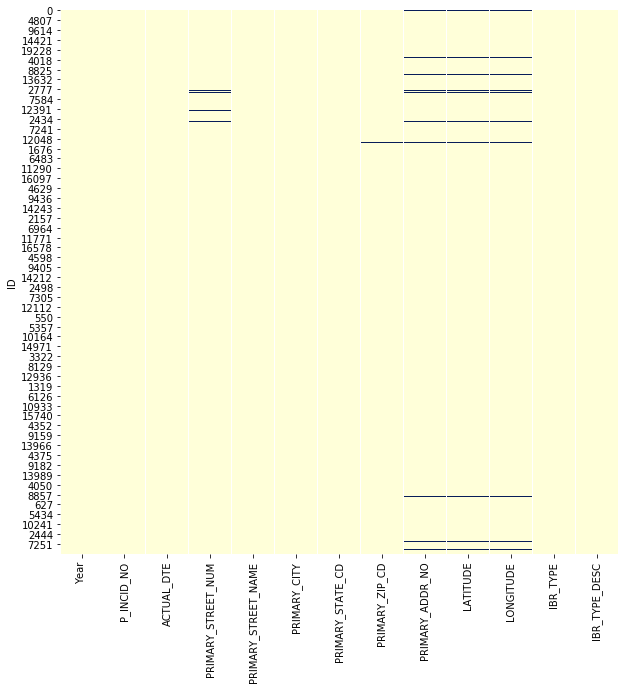

In [8]:
# Let's see how many null elements are contained in the data
plt.figure(figsize=(10,10))
sns.heatmap(data.isnull(), cbar = False, cmap = 'YlGnBu')
data.ACTUAL_DTE = pd.to_datetime(data.ACTUAL_DTE, format='%m/%d/%Y %H:%M:%S')


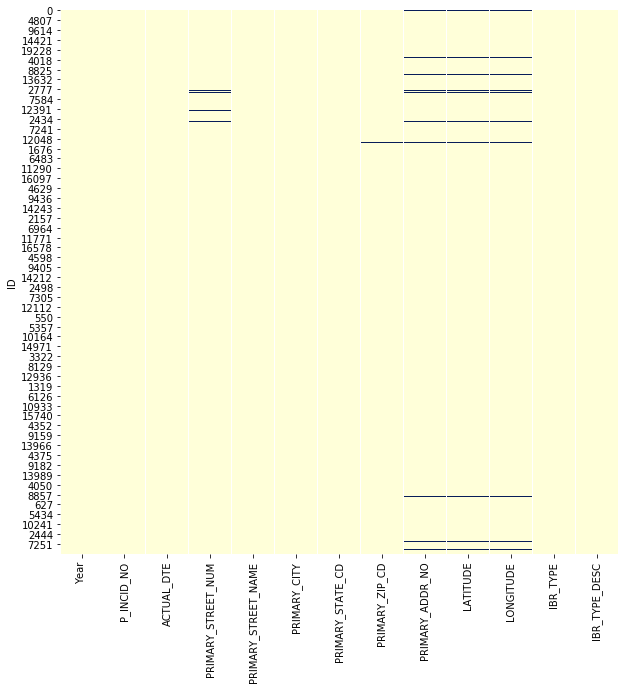

In [9]:
# Let's see how many null elements are contained in the data
plt.figure(figsize=(10,10))
sns.heatmap(data.isnull(), cbar = False, cmap = 'YlGnBu')
data.ACTUAL_DTE = pd.to_datetime(data.ACTUAL_DTE, format='%m/%d/%Y %H:%M')

In [10]:
# setting the index to be the date 
data.index = pd.DatetimeIndex(data.ACTUAL_DTE)


Text(0, 0.5, 'Number of Crimes')

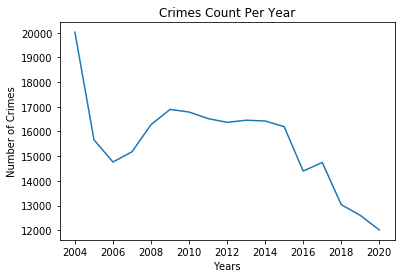

In [11]:
# Resample is a Convenience method for frequency conversion and resampling of time series.

plt.plot(data.resample('Y').size())
plt.title('Crimes Count Per Year')
plt.xlabel('Years')
plt.ylabel('Number of Crimes')


In [12]:
data.resample('M').size()


ACTUAL_DTE
2003-01-31    1818
2003-02-28    1254
2003-03-31    1579
2003-04-30    1538
2003-05-31    1826
2003-06-30    1902
2003-07-31    1821
2003-08-31    1634
2003-09-30    1807
2003-10-31    1703
2003-11-30    1667
2003-12-31    1468
2004-01-31    1462
2004-02-29    1402
2004-03-31    1334
2004-04-30    1301
2004-05-31    1384
2004-06-30    1387
2004-07-31    1349
2004-08-31    1274
2004-09-30    1213
2004-10-31    1239
2004-11-30    1169
2004-12-31    1148
2005-01-31    1038
2005-02-28    1013
2005-03-31    1142
2005-04-30    1266
2005-05-31    1346
2005-06-30    1389
              ... 
2017-07-31    1201
2017-08-31    1328
2017-09-30    1066
2017-10-31    1111
2017-11-30    1093
2017-12-31     949
2018-01-31    1034
2018-02-28    1020
2018-03-31    1063
2018-04-30    1015
2018-05-31    1098
2018-06-30    1107
2018-07-31    1178
2018-08-31    1068
2018-09-30    1029
2018-10-31     999
2018-11-30    1012
2018-12-31     981
2019-01-31     945
2019-02-28     769
2019-03-31     854
2

Text(0, 0.5, 'Number of Crimes')

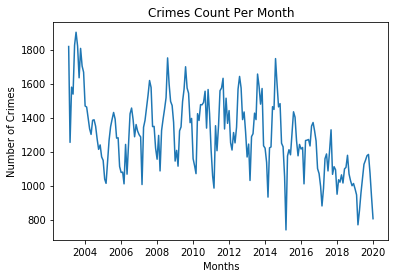

In [14]:
# Resample is a Convenience method for frequency conversion and resampling of time series.

plt.plot(data.resample('M').size())
plt.title('Crimes Count Per Month')
plt.xlabel('Months')
plt.ylabel('Number of Crimes')

In [15]:
data.resample('Q').size()

ACTUAL_DTE
2003-03-31    4651
2003-06-30    5266
2003-09-30    5262
2003-12-31    4838
2004-03-31    4198
2004-06-30    4072
2004-09-30    3836
2004-12-31    3556
2005-03-31    3193
2005-06-30    4001
2005-09-30    4100
2005-12-31    3470
2006-03-31    3331
2006-06-30    3738
2006-09-30    4131
2006-12-31    3979
2007-03-31    3635
2007-06-30    4374
2007-09-30    4542
2007-12-31    3724
2008-03-31    3705
2008-06-30    4358
2008-09-30    4843
2008-12-31    3987
2009-03-31    3643
2009-06-30    4405
2009-09-30    4816
2009-12-31    3923
2010-03-31    3608
2010-06-30    4334
              ... 
2012-09-30    4604
2012-12-31    3917
2013-03-31    3562
2013-06-30    4119
2013-09-30    4718
2013-12-31    4025
2014-03-31    3290
2014-06-30    4139
2014-09-30    4807
2014-12-31    3959
2015-03-31    2965
2015-06-30    3700
2015-09-30    4101
2015-12-31    3632
2016-03-31    3499
2016-06-30    3771
2016-09-30    4044
2016-12-31    3432
2017-03-31    2859
2017-06-30    3430
2017-09-30    3595
2

Text(0, 0.5, 'Number of Crimes')

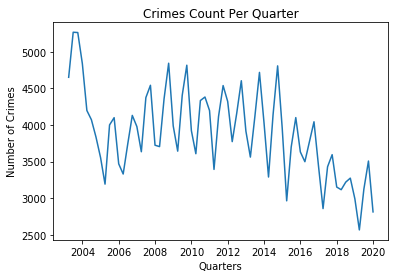

In [16]:
# Resample is a Convenience method for frequency conversion and resampling of time series.

plt.plot(data.resample('Q').size())
plt.title('Crimes Count Per Quarter')
plt.xlabel('Quarters')
plt.ylabel('Number of Crimes')

In [18]:
#Preparing the data for the prediction by using prophet
data_prophet = data.resample('M').size().reset_index()

In [19]:
data_prophet


,ACTUAL_DTE,0
0,2003-01-31,1818
1,2003-02-28,1254
2,2003-03-31,1579
3,2003-04-30,1538
4,2003-05-31,1826
5,2003-06-30,1902
6,2003-07-31,1821
7,2003-08-31,1634
8,2003-09-30,1807
9,2003-10-31,1703


In [20]:
data_prophet.columns = ['Date', 'Crime Count']

In [21]:
data_prophet

,Date,Crime Count
0,2003-01-31,1818
1,2003-02-28,1254
2,2003-03-31,1579
3,2003-04-30,1538
4,2003-05-31,1826
5,2003-06-30,1902
6,2003-07-31,1821
7,2003-08-31,1634
8,2003-09-30,1807
9,2003-10-31,1703


In [22]:
data_prophet_df = pd.DataFrame(data_prophet)

In [23]:
data_prophet_df


,Date,Crime Count
0,2003-01-31,1818
1,2003-02-28,1254
2,2003-03-31,1579
3,2003-04-30,1538
4,2003-05-31,1826
5,2003-06-30,1902
6,2003-07-31,1821
7,2003-08-31,1634
8,2003-09-30,1807
9,2003-10-31,1703


In [24]:
#renaming the columns in order to adapt it to the prediction
data_prophet_df2 = data_prophet_df.rename(columns={'Date':'ds', 'Crime Count':'y'})

In [25]:
data_prophet_df2

,ds,y
0,2003-01-31,1818
1,2003-02-28,1254
2,2003-03-31,1579
3,2003-04-30,1538
4,2003-05-31,1826
5,2003-06-30,1902
6,2003-07-31,1821
7,2003-08-31,1634
8,2003-09-30,1807
9,2003-10-31,1703


In [26]:
m = Prophet()
m.fit(data_prophet_df2)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [27]:
# Forcasting into the future
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)

In [28]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2003-01-31,1623.838272,1355.787740,1615.185910,1623.838272,1623.838272,-133.831281,-133.831281,-133.831281,-133.831281,-133.831281,-133.831281,0.0,0.0,0.0,1490.006991
1,2003-02-28,1614.380907,1096.114818,1351.535199,1614.380907,1614.380907,-388.941285,-388.941285,-388.941285,-388.941285,-388.941285,-388.941285,0.0,0.0,0.0,1225.439623
2,2003-03-31,1603.910253,1417.081405,1650.309812,1603.910253,1603.910253,-80.905659,-80.905659,-80.905659,-80.905659,-80.905659,-80.905659,0.0,0.0,0.0,1523.004594
3,2003-04-30,1593.777361,1382.724045,1624.889141,1593.777361,1593.777361,-88.657669,-88.657669,-88.657669,-88.657669,-88.657669,-88.657669,0.0,0.0,0.0,1505.119692
4,2003-05-31,1583.306707,1506.377942,1738.846596,1583.306707,1583.306707,40.309684,40.309684,40.309684,40.309684,40.309684,40.309684,0.0,0.0,0.0,1623.616391
5,2003-06-30,1573.173816,1564.321186,1814.295660,1573.173816,1573.173816,118.314859,118.314859,118.314859,118.314859,118.314859,118.314859,0.0,0.0,0.0,1691.488674
6,2003-07-31,1562.703161,1606.435805,1870.357462,1562.703161,1562.703161,170.751494,170.751494,170.751494,170.751494,170.751494,170.751494,0.0,0.0,0.0,1733.454656
7,2003-08-31,1552.232507,1554.274692,1809.582543,1552.232507,1552.232507,123.348323,123.348323,123.348323,123.348323,123.348323,123.348323,0.0,0.0,0.0,1675.580830
8,2003-09-30,1542.099616,1432.029658,1681.236819,1542.099616,1542.099616,10.704480,10.704480,10.704480,10.704480,10.704480,10.704480,0.0,0.0,0.0,1552.804096
9,2003-10-31,1531.628962,1423.215410,1681.055313,1531.628962,1531.628962,18.599712,18.599712,18.599712,18.599712,18.599712,18.599712,0.0,0.0,0.0,1550.228674


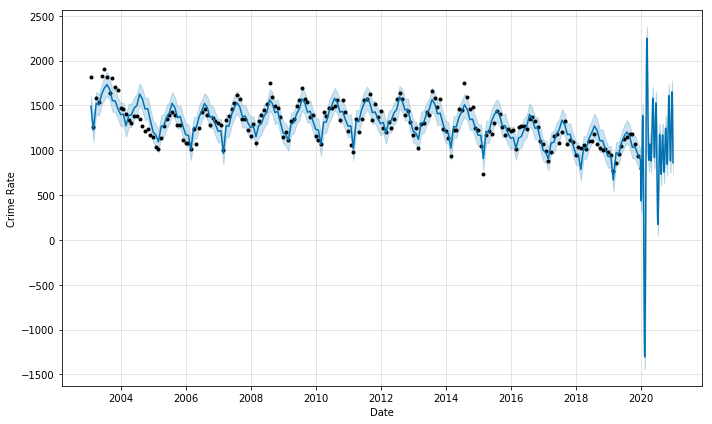

In [29]:
#Visualize
figure = m.plot(forecast, xlabel='Date', ylabel='Crime Rate')

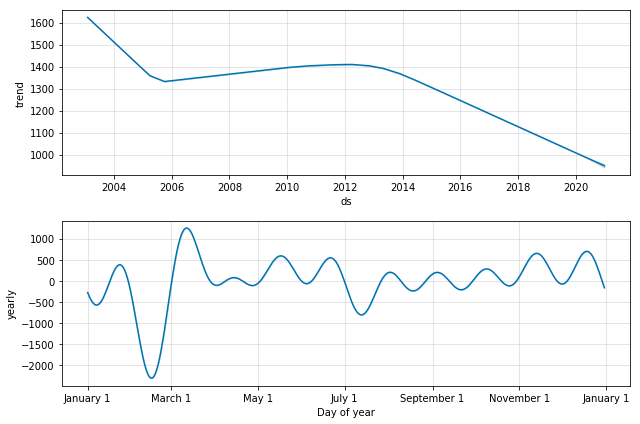

In [30]:
figure3 = m.plot_components(forecast)

In [31]:
try:
  data2 = pd.read_csv('WorcesterData_03_19.csv',index_col=0)
  print('Success: Data loaded into dataframe.')
except Exception as e:
    print('Data load error: ',e)

Success: Data loaded into dataframe.


In [32]:
data2.dronpna()

AttributeError: 'DataFrame' object has no attribute 'dronpna'

In [36]:
data3= data2.dropna()

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



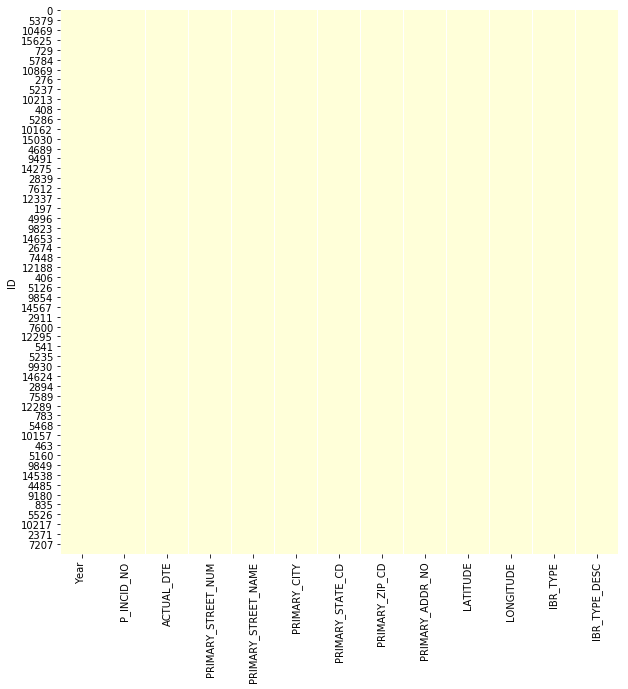

In [37]:
# Let's see how many null elements are contained in the data
plt.figure(figsize=(10,10))
sns.heatmap(data3.isnull(), cbar = False, cmap = 'YlGnBu')
data3.ACTUAL_DTE = pd.to_datetime(data3.ACTUAL_DTE, format='%m/%d/%Y %H:%M')

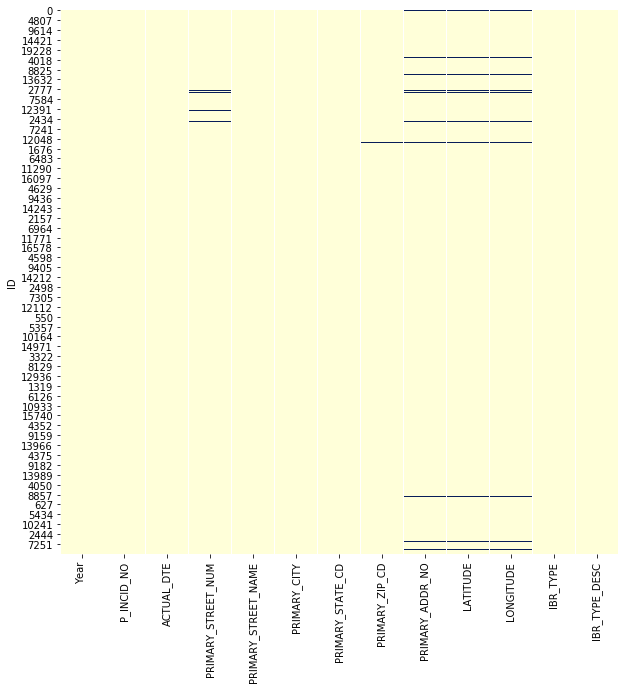

In [35]:
# Let's see how many null elements are contained in the data
plt.figure(figsize=(10,10))
sns.heatmap(data2.isnull(), cbar = False, cmap = 'YlGnBu')
data2.ACTUAL_DTE = pd.to_datetime(data2.ACTUAL_DTE, format='%m/%d/%Y %H:%M')

In [38]:
# setting the index to be the date 
data3.index = pd.DatetimeIndex(data3.ACTUAL_DTE)

Text(0, 0.5, 'Number of Crimes')

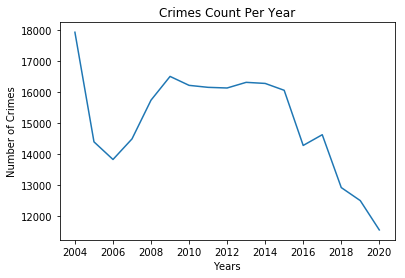

In [39]:
# Resample is a Convenience method for frequency conversion and resampling of time series.

plt.plot(data3.resample('Y').size())
plt.title('Crimes Count Per Year')
plt.xlabel('Years')
plt.ylabel('Number of Crimes')

ACTUAL_DTE
2003-03-31    4651
2003-06-30    5266
2003-09-30    5262
2003-12-31    4838
2004-03-31    4198
2004-06-30    4072
2004-09-30    3836
2004-12-31    3556
2005-03-31    3193
2005-06-30    4001
2005-09-30    4100
2005-12-31    3470
2006-03-31    3331
2006-06-30    3738
2006-09-30    4131
2006-12-31    3979
2007-03-31    3635
2007-06-30    4374
2007-09-30    4542
2007-12-31    3724
2008-03-31    3705
2008-06-30    4358
2008-09-30    4843
2008-12-31    3987
2009-03-31    3643
2009-06-30    4405
2009-09-30    4816
2009-12-31    3923
2010-03-31    3608
2010-06-30    4334
              ... 
2012-09-30    4604
2012-12-31    3917
2013-03-31    3562
2013-06-30    4119
2013-09-30    4718
2013-12-31    4025
2014-03-31    3290
2014-06-30    4139
2014-09-30    4807
2014-12-31    3959
2015-03-31    2965
2015-06-30    3700
2015-09-30    4101
2015-12-31    3632
2016-03-31    3499
2016-06-30    3771
2016-09-30    4044
2016-12-31    3432
2017-03-31    2859
2017-06-30    3430
2017-09-30    3595
2

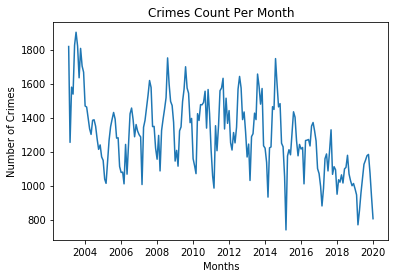

In [40]:
#Resampling the data
data.resample('M').size()

# Resample is a Convenience method for frequency conversion and resampling of time series.

plt.plot(data.resample('M').size())
plt.title('Crimes Count Per Month')
plt.xlabel('Months')
plt.ylabel('Number of Crimes')
data.resample('Q').size()


ACTUAL_DTE
2003-03-31    4651
2003-06-30    5266
2003-09-30    5262
2003-12-31    4838
2004-03-31    4198
2004-06-30    4072
2004-09-30    3836
2004-12-31    3556
2005-03-31    3193
2005-06-30    4001
2005-09-30    4100
2005-12-31    3470
2006-03-31    3331
2006-06-30    3738
2006-09-30    4131
2006-12-31    3979
2007-03-31    3635
2007-06-30    4374
2007-09-30    4542
2007-12-31    3724
2008-03-31    3705
2008-06-30    4358
2008-09-30    4843
2008-12-31    3987
2009-03-31    3643
2009-06-30    4405
2009-09-30    4816
2009-12-31    3923
2010-03-31    3608
2010-06-30    4334
              ... 
2012-09-30    4604
2012-12-31    3917
2013-03-31    3562
2013-06-30    4119
2013-09-30    4718
2013-12-31    4025
2014-03-31    3290
2014-06-30    4139
2014-09-30    4807
2014-12-31    3959
2015-03-31    2965
2015-06-30    3700
2015-09-30    4101
2015-12-31    3632
2016-03-31    3499
2016-06-30    3771
2016-09-30    4044
2016-12-31    3432
2017-03-31    2859
2017-06-30    3430
2017-09-30    3595
2

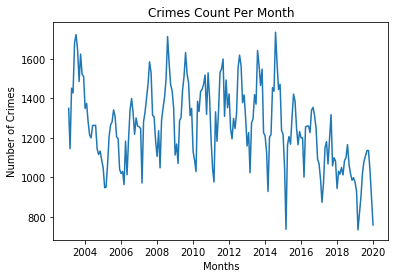

In [41]:
#Resampling the data
data3.resample('M').size()

# Resample is a Convenience method for frequency conversion and resampling of time series.

plt.plot(data3.resample('M').size())
plt.title('Crimes Count Per Month')
plt.xlabel('Months')
plt.ylabel('Number of Crimes')
data.resample('Q').size()


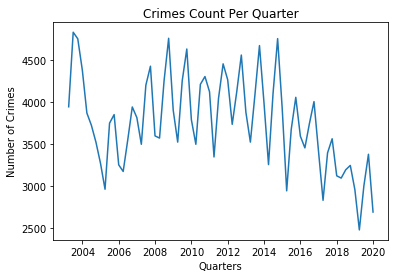

In [42]:
# Resample is a Convenience method for frequency conversion and resampling of time series.

plt.plot(data3.resample('Q').size())
plt.title('Crimes Count Per Quarter')
plt.xlabel('Quarters')
plt.ylabel('Number of Crimes')

#Preparing the data for the prediction by using prophet
data_prophet = data3.resample('M').size().reset_index()

In [43]:
data_prophet
data_prophet.columns = ['Date', 'Crime Count']
data_prophet
data_prophet_df = pd.DataFrame(data_prophet)
data_prophet_df

,Date,Crime Count
0,2003-01-31,1350
1,2003-02-28,1145
2,2003-03-31,1452
3,2003-04-30,1428
4,2003-05-31,1684
5,2003-06-30,1724
6,2003-07-31,1647
7,2003-08-31,1486
8,2003-09-30,1625
9,2003-10-31,1522


In [44]:
#renaming the columns in order to adapt it to the prediction
data_prophet_df2 = data_prophet_df.rename(columns={'Date':'ds', 'Crime Count':'y'})

data_prophet_df2

,ds,y
0,2003-01-31,1350
1,2003-02-28,1145
2,2003-03-31,1452
3,2003-04-30,1428
4,2003-05-31,1684
5,2003-06-30,1724
6,2003-07-31,1647
7,2003-08-31,1486
8,2003-09-30,1625
9,2003-10-31,1522


In [45]:
m = Prophet()
m.fit(data_prophet_df2)


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [46]:
# Forcasting into the future
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)

forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2003-01-31,1396.519644,1114.347374,1372.590760,1396.519644,1396.519644,-144.826866,-144.826866,-144.826866,-144.826866,-144.826866,-144.826866,0.0,0.0,0.0,1251.692778
1,2003-02-28,1393.240307,882.120597,1145.941458,1393.240307,1393.240307,-380.759729,-380.759729,-380.759729,-380.759729,-380.759729,-380.759729,0.0,0.0,0.0,1012.480578
2,2003-03-31,1389.609612,1190.882887,1434.108258,1389.609612,1389.609612,-78.710049,-78.710049,-78.710049,-78.710049,-78.710049,-78.710049,0.0,0.0,0.0,1310.899563
3,2003-04-30,1386.096037,1167.223542,1428.832872,1386.096037,1386.096037,-87.559597,-87.559597,-87.559597,-87.559597,-87.559597,-87.559597,0.0,0.0,0.0,1298.536439
4,2003-05-31,1382.465342,1300.987538,1557.995990,1382.465342,1382.465342,43.971531,43.971531,43.971531,43.971531,43.971531,43.971531,0.0,0.0,0.0,1426.436873
5,2003-06-30,1378.951767,1356.451440,1614.127921,1378.951767,1378.951767,111.083445,111.083445,111.083445,111.083445,111.083445,111.083445,0.0,0.0,0.0,1490.035212
6,2003-07-31,1375.321073,1419.625413,1673.764213,1375.321073,1375.321073,167.882931,167.882931,167.882931,167.882931,167.882931,167.882931,0.0,0.0,0.0,1543.204003
7,2003-08-31,1371.690378,1359.657878,1623.991940,1371.690378,1371.690378,119.632042,119.632042,119.632042,119.632042,119.632042,119.632042,0.0,0.0,0.0,1491.322420
8,2003-09-30,1368.176803,1239.000888,1503.899325,1368.176803,1368.176803,2.469394,2.469394,2.469394,2.469394,2.469394,2.469394,0.0,0.0,0.0,1370.646197
9,2003-10-31,1364.546108,1237.877570,1502.633140,1364.546108,1364.546108,10.293705,10.293705,10.293705,10.293705,10.293705,10.293705,0.0,0.0,0.0,1374.839813


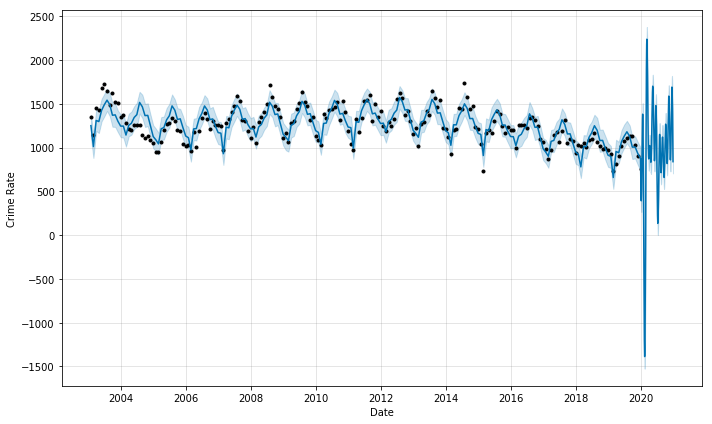

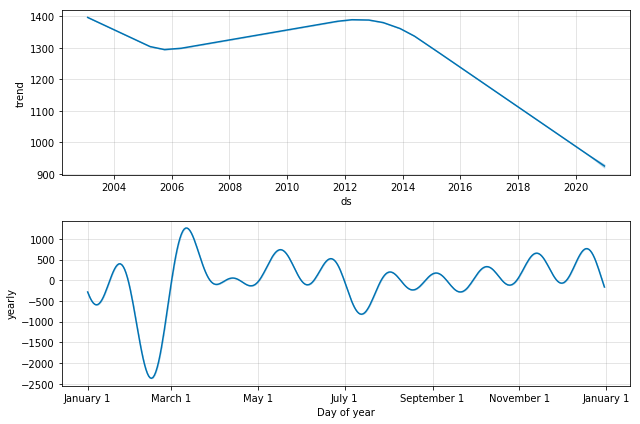

In [47]:
#Visualize
figure = m.plot(forecast, xlabel='Date', ylabel='Crime Rate')

#Visualizing the trend for the future years 
figure3 = m.plot_components(forecast)